**2d Plot from Amin's code**

In [1]:
import open3d as o3d
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
class LineNode:
    def __init__(self, id: int, lineset: o3d.geometry.LineSet, neighbors: set[int]):
        self.id = id
        self.lineset = lineset
        self.neighbors = neighbors

class LineGraph:
    def __init__(self, linenodes):
        self.nodes = linenodes

    def insert_linenode(self, linenode: LineNode):
        self.nodes[linenode.id] = linenode

    def get_node(self, id: int):
        return self.nodes[id]

In [3]:
def read_linesets():
    
    # Extract the road points
    road_points_df = pd.read_excel('/Users/mgoli1/Documents/P/Project/AutonoDES/Software/Data/11 Dec/road_points.xlsx', header=None)
    road_points_df = road_points_df.apply(pd.to_numeric, errors='coerce')
    linesets = {}

    for group_id, group in road_points_df.groupby(0):
        points = group.iloc[:, 1:].to_numpy()
        lines = [[i, i+1] for i in range(len(points)-1)]
        lineset = o3d.geometry.LineSet()
        lineset.points = o3d.utility.Vector3dVector(points)
        lineset.lines = o3d.utility.Vector2iVector(lines)
        lineset.paint_uniform_color([0, 0, 1])
        linesets[group_id] = lineset

    nodes = {}
    for x in range(1, len(linesets) + 1):
        nodes[x] = LineNode(x, linesets[x], set())

    for linenode in nodes.values():
        id = linenode.id
        lineset = linenode.lineset
        for other_id in range(1, len(linesets)+1):
            if other_id == id: continue
            if other_id in nodes[id].neighbors: continue

            points_one = np.asarray(lineset.points)
            points_two = np.asarray(linesets[other_id].points)
            for point_1_id in range(points_one.shape[0]):
                for point_2_id in range(points_two.shape[0]):
                    if np.all(np.equal(points_one[point_1_id, :], points_two[point_2_id, :])):
                        nodes[id].neighbors.add(other_id)
                        nodes[other_id].neighbors.add(id)

    global graph
    graph = LineGraph(nodes)


# Call the function to read linesets and plot the graph
read_linesets()


**New added part to the previous code for plot**

In [12]:
# Read destinations.csv, sources.csv, and ancillary.csv
destinations_df = pd.read_csv('Destinations.csv')
sources_df = pd.read_csv('Sources.csv')
ancillary_df = pd.read_csv('Ancillary.csv')

# Merge all DataFrames into one DataFrame containing all the locations
locations_df = pd.concat([destinations_df, sources_df,ancillary_df], ignore_index=True)

# Save the merged DataFrame as "locations.csv"
locations_df.to_csv('Locations.csv', index=False)

In [15]:
class Location:
    def __init__(self, name, coordinates):
        self.name = name
        self.coordinates = coordinates
        
def read_locations():
    # Read location points from a CSV file
    location_df = pd.read_csv('Locations.csv')
    
    locations = []
    for _, row in location_df.iterrows():
        name = row['Name']
        coordinates = [row['X'], row['Y']]
        locations.append(Location(name, coordinates))
    
    return locations

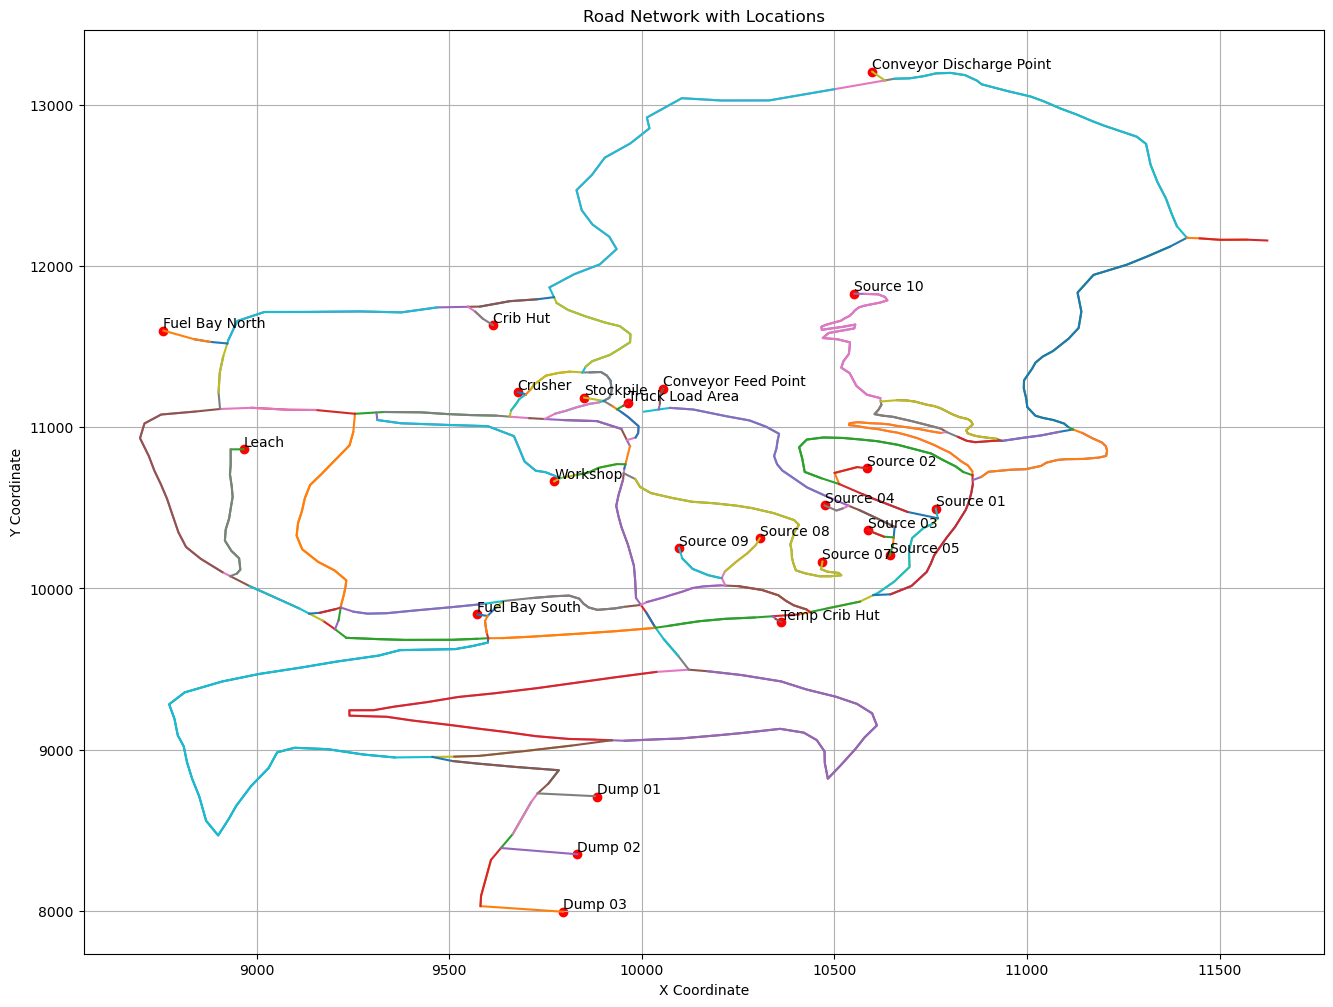

In [16]:
import matplotlib.pyplot as plt
def plot_graph_2d(graph, locations):
    plt.figure(figsize=(16, 12))
    
    # Plot each line set in 2D
    for linenode in graph.nodes.values():
        points = np.asarray(linenode.lineset.points)
        plt.plot(points[:, 0], points[:, 1], label=f'Line {linenode.id}')
    
    # Display node names if corresponding location exists
    for location in locations:
        plt.scatter(location.coordinates[0], location.coordinates[1], color='red')
        plt.text(location.coordinates[0], location.coordinates[1], location.name, fontsize=10, ha='left', va='bottom')

    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Road Network with Locations')
    plt.grid(True)
    plt.show()

# Call the function to read linesets and locations, and plot the graph
locations = read_locations()
plot_graph_2d(graph, locations)